In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd # not for students, install from anaconda gui
# ^^ Had dependency issues when installing geopandas from cli, but I remember an issue with fiona package...
# Also need to install descartes through anaconda gui, but don't need to import?
import numpy as np
import re
from shapely.geometry import Point
import sqlite3 as sql
from sqlalchemy import create_engine

%matplotlib inline

In [2]:
pd.set_option('max_colwidth', 500)

In [3]:
permits = pd.read_csv('data/Building_Permits_Issued.csv', low_memory=False)
print(permits.shape)
permits.head()

(34474, 20)


,Permit #,Permit Type Description,Permit Subtype Description,Parcel,Date Entered,Date Issued,Construction Cost,Address,City,State,ZIP,Subdivision / Lot,Contact,Permit Type,Permit Subtype,IVR Tracking #,Purpose,Council District,Census Tract,Mapped Location
0,2019067152,Building Demolition Permit,Demolition Permit - Residential,06106005200,11/01/2019,11/01/2019,6000.0,600 MAPLEWOOD LN,NASHVILLE,TN,37216,S SIDE MAPLEWOOD LANE & W OF HUTSON AVE,CONTRERAS DESIGN BUILD LLC,CADM,CAZ01A001,3728422,"to demolish existing residence and detached storage building. not to be burned on lot. for every 50' site frontage, a 24 x 36 d/f sign must be placed in English and Spanish with information in regards to metro council bill 2017-835.",8.0,37011002.0,"600 MAPLEWOOD LN\nNASHVILLE, TN 37216\n(36.228473, -86.740798)"
1,2019011084,Building Use & Occupancy,"Multifamily, Townhome",051100J90000CO,02/25/2019,07/22/2019,0.0,812 BRIAR CIR,MADISON,TN,37115,COMMON AREA HOMES AT BRIAR,COLE INVESTMENTS LLC,CAUO,CAA03R301,3611315,"MASTER PERMIT ONLY� � NO CONSTRUCTION� �MULTI-FAMILY SP� � 17 DETACHED RESIDENTIAL UNITS� � \n\nMUST COMPLY WITH SPECIFIC PLAN (SP) 2017SP-093 \n\nPARCELS 05110004000, 05110004100 AND 05110004200 MUST BE COMBINED",8.0,37010802.0,"812 BRIAR CIR\nMADISON, TN 37115"
2,2019011479,Building Commercial - Rehab,Restaurant (Full Service),11714005500,02/27/2019,07/22/2019,759670.0,2171 GREEN HILLS VILLAGE DR,NASHVILLE,TN,37215,W/S HILLSBORO PK. & N/S ABBOTT MARTIN RD.,"BATTINO CONTRACTING SOLUTIONS, LLC",CACR,CAF19A203,3613106,2475 sq.ft. build out of CAVA RESTURANT to include new kitchen\nPOC ADAM TOAL 202-719-0111,25.0,37017901.0,"2171 GREEN HILLS VILLAGE DR\nNASHVILLE, TN 37215\n(36.108463, -86.814234)"
3,2019039568,Building Residential - New,Single Family Residence,085040A40800CO,07/03/2019,07/22/2019,300888.0,4327 STONE HALL BLVD,HERMITAGE,TN,37076,LOT 408 THE RESERVE AT STONE HALL PH 2 SEC 1,MERITAGE HOMES OF TENNESSEE INC,CARN,CAA01R301,3687554,"New Single Family construction - Total Sq footage 4133 - 1st fl 1076; 2nd fl 939; Finished basement 656; unfinished basement 939; garage 417; porch/patio 106. PUDR. must comply with tree regulations one new two inch tree for every 30' road frontage. for every 50' site frontage, a 24 x 36 d/f sign must be placed in English and Spanish with information in regards to metro council bill 2017-835.",14.0,37015402.0,"4327 STONE HALL BLVD\nHERMITAGE, TN 37076"
4,2017000049,Building Residential - New,Single Family Residence,164100A43100CO,01/03/2017,01/09/2017,268107.0,704 ABERCORN CT,ANTIOCH,TN,37013,LOT 79 SUMMERFIELD SUBDIVISION VILLAGE TEN,"NVR, INC. T/A RYAN HOMES",CARN,CAA01R301,3306701,"TO CONSTRUCT A NEW SINGLE FAMILY RES AT 2380 SQFT WITH ATTACHED GARAGE AT 421 SQFT WITH PORCHES AND DECKS.....SETBACKS MIN 20'...REAR MIN 20'..SIDE MIN 5'...SEE PLAN..For every 30 feet of LOT frontage, or fraction thereof, one 2 inch caliper tree as listed in the Urban Forestry approved tree list shall be planted on the subject property....Pursuant Ordinance # 2006-1263 Metropolitan code of Laws, I (the holder on this permit) hereby certify that all construction & demolition waste generat...",32.0,37015630.0,"704 ABERCORN CT\nANTIOCH, TN 37013\n(36.045042, -86.616211)"


In [4]:
permits.columns

Index(['Permit #', 'Permit Type Description', 'Permit Subtype Description',
       'Parcel', 'Date Entered', 'Date Issued', 'Construction Cost', 'Address',
       'City', 'State', 'ZIP', 'Subdivision / Lot', 'Contact', 'Permit Type',
       'Permit Subtype', 'IVR Tracking #', 'Purpose', 'Council District',
       'Census Tract', 'Mapped Location'],
      dtype='object')

In [5]:
permits.columns = ['number', 'type_desc', 'subtype_desc', 'parcel', 'enter_date', 'issue_date', 'cost', 'address', 'city', 
                   'state', 'zip', 'subdivision', 'contact', 'type_code', 'subtype_code', 'tracking_number', 'purpose', 'council_district',
                   'census_tract', 'mapped_location']

In [6]:
permits.head()

,number,type_desc,subtype_desc,parcel,enter_date,issue_date,cost,address,city,state,zip,subdivision,contact,type_code,subtype_code,tracking_number,purpose,council_district,census_tract,mapped_location
0,2019067152,Building Demolition Permit,Demolition Permit - Residential,06106005200,11/01/2019,11/01/2019,6000.0,600 MAPLEWOOD LN,NASHVILLE,TN,37216,S SIDE MAPLEWOOD LANE & W OF HUTSON AVE,CONTRERAS DESIGN BUILD LLC,CADM,CAZ01A001,3728422,"to demolish existing residence and detached storage building. not to be burned on lot. for every 50' site frontage, a 24 x 36 d/f sign must be placed in English and Spanish with information in regards to metro council bill 2017-835.",8.0,37011002.0,"600 MAPLEWOOD LN\nNASHVILLE, TN 37216\n(36.228473, -86.740798)"
1,2019011084,Building Use & Occupancy,"Multifamily, Townhome",051100J90000CO,02/25/2019,07/22/2019,0.0,812 BRIAR CIR,MADISON,TN,37115,COMMON AREA HOMES AT BRIAR,COLE INVESTMENTS LLC,CAUO,CAA03R301,3611315,"MASTER PERMIT ONLY� � NO CONSTRUCTION� �MULTI-FAMILY SP� � 17 DETACHED RESIDENTIAL UNITS� � \n\nMUST COMPLY WITH SPECIFIC PLAN (SP) 2017SP-093 \n\nPARCELS 05110004000, 05110004100 AND 05110004200 MUST BE COMBINED",8.0,37010802.0,"812 BRIAR CIR\nMADISON, TN 37115"
2,2019011479,Building Commercial - Rehab,Restaurant (Full Service),11714005500,02/27/2019,07/22/2019,759670.0,2171 GREEN HILLS VILLAGE DR,NASHVILLE,TN,37215,W/S HILLSBORO PK. & N/S ABBOTT MARTIN RD.,"BATTINO CONTRACTING SOLUTIONS, LLC",CACR,CAF19A203,3613106,2475 sq.ft. build out of CAVA RESTURANT to include new kitchen\nPOC ADAM TOAL 202-719-0111,25.0,37017901.0,"2171 GREEN HILLS VILLAGE DR\nNASHVILLE, TN 37215\n(36.108463, -86.814234)"
3,2019039568,Building Residential - New,Single Family Residence,085040A40800CO,07/03/2019,07/22/2019,300888.0,4327 STONE HALL BLVD,HERMITAGE,TN,37076,LOT 408 THE RESERVE AT STONE HALL PH 2 SEC 1,MERITAGE HOMES OF TENNESSEE INC,CARN,CAA01R301,3687554,"New Single Family construction - Total Sq footage 4133 - 1st fl 1076; 2nd fl 939; Finished basement 656; unfinished basement 939; garage 417; porch/patio 106. PUDR. must comply with tree regulations one new two inch tree for every 30' road frontage. for every 50' site frontage, a 24 x 36 d/f sign must be placed in English and Spanish with information in regards to metro council bill 2017-835.",14.0,37015402.0,"4327 STONE HALL BLVD\nHERMITAGE, TN 37076"
4,2017000049,Building Residential - New,Single Family Residence,164100A43100CO,01/03/2017,01/09/2017,268107.0,704 ABERCORN CT,ANTIOCH,TN,37013,LOT 79 SUMMERFIELD SUBDIVISION VILLAGE TEN,"NVR, INC. T/A RYAN HOMES",CARN,CAA01R301,3306701,"TO CONSTRUCT A NEW SINGLE FAMILY RES AT 2380 SQFT WITH ATTACHED GARAGE AT 421 SQFT WITH PORCHES AND DECKS.....SETBACKS MIN 20'...REAR MIN 20'..SIDE MIN 5'...SEE PLAN..For every 30 feet of LOT frontage, or fraction thereof, one 2 inch caliper tree as listed in the Urban Forestry approved tree list shall be planted on the subject property....Pursuant Ordinance # 2006-1263 Metropolitan code of Laws, I (the holder on this permit) hereby certify that all construction & demolition waste generat...",32.0,37015630.0,"704 ABERCORN CT\nANTIOCH, TN 37013\n(36.045042, -86.616211)"


---

In [7]:
permits.info()

# type_desc, subtype_desc, cost, issue_date - enter_date, zip, contact?, type_code, concil_district

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34474 entries, 0 to 34473
Data columns (total 20 columns):
number              34474 non-null object
type_desc           34474 non-null object
subtype_desc        34474 non-null object
parcel              34474 non-null object
enter_date          34474 non-null object
issue_date          34474 non-null object
cost                34458 non-null float64
address             34474 non-null object
city                34472 non-null object
state               34472 non-null object
zip                 34474 non-null int64
subdivision         34474 non-null object
contact             34473 non-null object
type_code           34474 non-null object
subtype_code        34474 non-null object
tracking_number     34474 non-null int64
purpose             34019 non-null object
council_district    34422 non-null float64
census_tract        34409 non-null float64
mapped_location     34474 non-null object
dtypes: float64(3), int64(2), object(15)
memory us

In [8]:
# do something where they have to separate residential and commercial permits
permits['type_desc'].value_counts()

Building Residential - New                  13142
Building Commercial - Rehab                  3457
Building Residential - Rehab                 3345
Building Residential - Addition              3264
Building Demolition Permit                   2855
Building Sign Permit                         2438
Building Use & Occupancy                     1572
Building Commercial - Tenant Finish Out      1063
Building Commercial - New                     972
Building Tree Removal Permit                  479
Building Commercial - Addition                477
Building Commercial - Roofing / Siding        255
Building Residential - Roofing / Siding       246
Building Commercial - Shell                   149
Building Blasting Permit                      144
Building Residential - Tenant Finish Out      143
Building Commercial - Foundation              109
Building Residential - Fire Damage             99
Building Residential - Change Contractor       91
Building Commercial - Fire Damage              52


In [9]:
# Maybe something with this, could be good for matplotlib bar plot
permits['subtype_desc'].value_counts()

Single Family Residence                  15965
Demolition Permit - Residential           2420
Sign - Ground /  Wall Signs               2343
Accessory Structure, Garage               1304
General Office, Professional Services     1294
                                         ...  
Comm. Amusement (Out), Bleachers             1
Small Outdoor Music Event                    1
Historical Bed & Breakfast, Hotel            1
College / University, Libraries              1
General Office, Courtrooms                   1
Name: subtype_desc, Length: 180, dtype: int64

In [10]:
permits['cost'].value_counts()

2000.0      929
1.0         883
5000.0      839
10000.0     647
15000.0     538
           ... 
629714.0      1
8743.0        1
5564.0        1
2299.0        1
14777.0       1
Name: cost, Length: 8104, dtype: int64

In [11]:
# What was the highest cost for a permit? What was the lowest? How many of each?
permits.describe()

,cost,zip,tracking_number,council_district,census_tract
count,3.445800e+04,34474.000000,3.447400e+04,34422.000000,3.440900e+04
mean,3.047219e+05,37153.689592,3.500911e+06,17.728604,1.555413e+08
std,2.169379e+06,942.331091,1.610342e+05,9.330480,2.319147e+09
min,0.000000e+00,0.000000,1.623298e+06,1.000000,1.250000e+04
25%,9.000000e+03,37203.000000,3.390344e+06,10.000000,3.701320e+07
50%,5.912900e+04,37208.000000,3.501985e+06,19.000000,3.701563e+07
75%,2.168230e+05,37211.000000,3.611583e+06,24.000000,3.701820e+07
max,1.314127e+08,37240.000000,3.740784e+06,35.000000,4.703702e+10


/Users/maheshrao/anaconda3/envs/jumpstart/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/maheshrao/anaconda3/envs/jumpstart/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


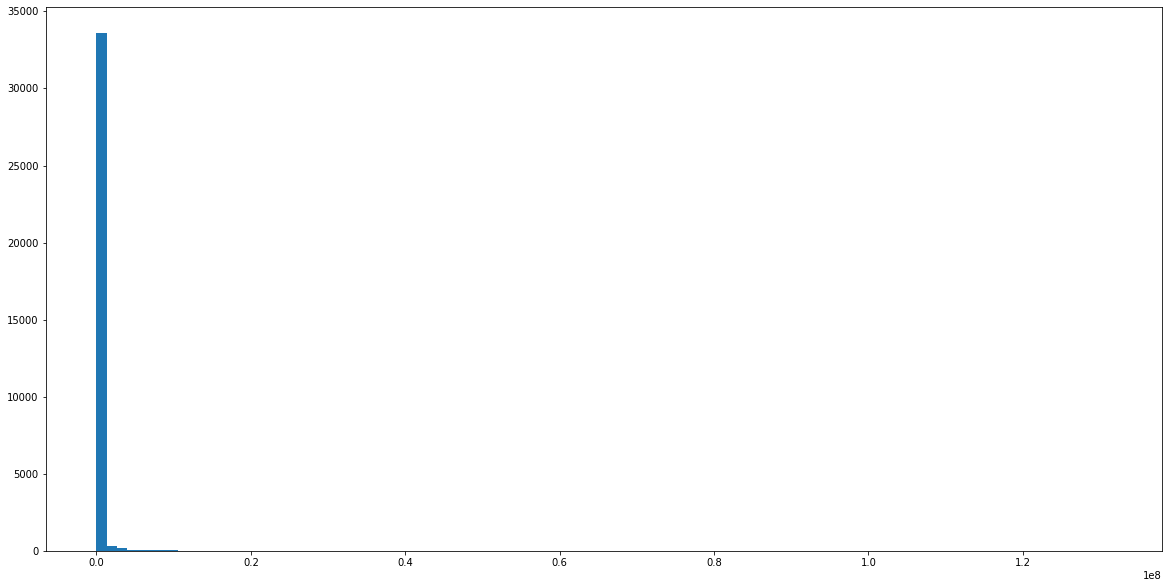

In [12]:
plt.figure(figsize = (20, 10))
plt.hist(permits['cost'], bins = 100);

In [13]:
# Which person or group had the most permits (exclude self contractors)?
permits['contact'].value_counts()

SELF CONTRACTOR RESIDENTIAL (SEE APPLICANT INFORMATION)    3061
SELF CONTRACTOR COMMERCIAL (SEE APPLICANT INFORMATION)      746
OLE SOUTH PROPERTIES INC                                    601
NVR, INC. T/A RYAN HOMES                                    581
JOSLIN SIGN & MAINTENANCE CO INC                            520
                                                           ... 
JACK PIRATAS PARTNERSHIP                                      1
Jonathan Sanders                                              1
DORRIS, PHILIP  CONSTRUCTION                                  1
SELF CONTRACTOR RESIDENTIAL (ROGER LEE)                       1
HARPETH RESTORATION, LLC                                      1
Name: contact, Length: 4555, dtype: int64

In [14]:
permits['zip'].value_counts()

37209    4005
37013    3092
37203    2511
37207    2261
37206    2065
37211    1974
37208    1930
37215    1450
37205    1299
37216    1290
37076    1277
37221    1242
37214    1174
37210    1133
37115    1131
37212    1075
37204     971
37217     729
37138     674
37218     508
37135     489
37027     463
37201     359
37219     322
37220     215
37072     181
37228     173
37189     172
37080     126
37213      60
37086      27
0          21
37122      18
37143      14
37064      13
37015      10
37238       9
37232       6
37240       1
37200       1
301         1
37235       1
27218       1
Name: zip, dtype: int64

In [15]:
permits['enter_date'] = pd.to_datetime(permits['enter_date'])
permits['issue_date'] = pd.to_datetime(permits['issue_date'])

In [16]:
permits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34474 entries, 0 to 34473
Data columns (total 20 columns):
number              34474 non-null object
type_desc           34474 non-null object
subtype_desc        34474 non-null object
parcel              34474 non-null object
enter_date          34474 non-null datetime64[ns]
issue_date          34474 non-null datetime64[ns]
cost                34458 non-null float64
address             34474 non-null object
city                34472 non-null object
state               34472 non-null object
zip                 34474 non-null int64
subdivision         34474 non-null object
contact             34473 non-null object
type_code           34474 non-null object
subtype_code        34474 non-null object
tracking_number     34474 non-null int64
purpose             34019 non-null object
council_district    34422 non-null float64
census_tract        34409 non-null float64
mapped_location     34474 non-null object
dtypes: datetime64[ns](2), float64

In [17]:
# What is the longest time a permit took to be issued?

permits['enter_date'] = pd.to_datetime(permits['enter_date'])
permits['issue_date'] = pd.to_datetime(permits['issue_date'])
(permits['issue_date']-permits['enter_date']).value_counts()

0 days       10804
1 days        2246
7 days        1123
6 days        1089
2 days        1080
             ...  
1212 days        1
701 days         1
421 days         1
540 days         1
1391 days        1
Length: 491, dtype: int64

In [18]:
# subset by year and compare

In [19]:
short_term_permits = pd.read_csv('data/Residential_Short_Term_Rental_Permits.csv')

In [20]:
short_term_permits.head()

,Permit #,Applicant,Applicant Home Phone,Applicant Mobile Phone,Applicant Work Phone,Applicant Work Phone Ext.,Contact,Contact Home Phone,Contact Mobile Phone,Contact Work Phone,...,Permit Owner Addr. 2,Permit Owner Addr. 3,Permit Owner City,Permit Owner State,Permit Owner ZIP,Permit Type,Permit Subtype,Council District,Census Tract,Mapped Location
0,2018054778,Brookside Properties,NaN,615-496-5085,NaN,NaN,Brookside Properties,NaN,615-496-5085,NaN,...,5039 HILL PLACE DR,NaN,NASHVILLE,TN,37205,CASR,CAZ10A003,19.0,37019500,"109 2ND AVE N 1\nNASHVILLE, TN 37201\n(36.162228, -86.775394)"
1,2017067571,NaN,NaN,NaN,NaN,NaN,Sarah Butler,NaN,615 364-9634,NaN,...,11 Music Sq. E #503,NaN,Nashville,TN,37203,CASR,CAZ10A003,19.0,37019500,"11 MUSIC SQ E 503\nNASHVILLE, TN 37203\n(36.15108, -86.791727)"
2,T2019048795,Shelley Matthews,NaN,757 373-4609,NaN,NaN,Shelley Matthews,NaN,757 373-4609,NaN,...,543 WESLEY AVE,NaN,NASHVILLE,TN,37207,CASR,CAZ10A001,5.0,37011300,"543 WESLEY AVE\nNASHVILLE, TN 37207\n(36.205997, -86.752678)"
3,2018071612,"Niido Nashville, LLC",NaN,808 343-0834,NaN,NaN,Niido Nashville,NaN,615 440-0755,NaN,...,NaN,NaN,MIAMI,FL,33131,CASR,CAZ10A003,19.0,37019500,"501 5TH AVE S 245\nNASHVILLE, TN 37203\n(36.155421, -86.775105)"
4,2017074493,Meredith Garrett,NaN,615 485-0700,NaN,NaN,Meredith Garrett,NaN,615 485-0700,NaN,...,1715 6TH AVE N UNIT B,NaN,NASHVILLE,TN,37208,CASR,CAZ10A001,19.0,37019400,"1715B 6TH AVE N\nNASHVILLE, TN 37208\n(36.18254, -86.794409)"


In [21]:
short_term_permits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9544 entries, 0 to 9543
Data columns (total 35 columns):
Permit #                      9544 non-null object
Applicant                     8459 non-null object
Applicant Home Phone          38 non-null object
Applicant Mobile Phone        4655 non-null object
Applicant Work Phone          1474 non-null object
Applicant Work Phone Ext.     2 non-null object
Contact                       9095 non-null object
Contact Home Phone            107 non-null object
Contact Mobile Phone          5555 non-null object
Contact Work Phone            3382 non-null object
Contact Work Phone Ext.       2 non-null object
Permit Subtype Description    9544 non-null object
Permit Status                 9544 non-null object
Parcel                        9544 non-null object
Date Entered                  9544 non-null object
Date Issued                   8421 non-null object
Expiration Date               9540 non-null object
Address                       9544 

In [22]:
short_term_permits.describe()

,ZIP,Council District,Census Tract
count,9544.000000,9537.000000,9.544000e+03
mean,37200.163349,15.245046,3.698855e+07
std,381.631220,7.068474,1.001788e+06
min,0.000000,1.000000,1.170000e+04
25%,37203.000000,7.000000,3.701260e+07
50%,37207.000000,18.000000,3.701630e+07
75%,37212.000000,19.000000,3.701900e+07
max,37228.000000,35.000000,3.701960e+07


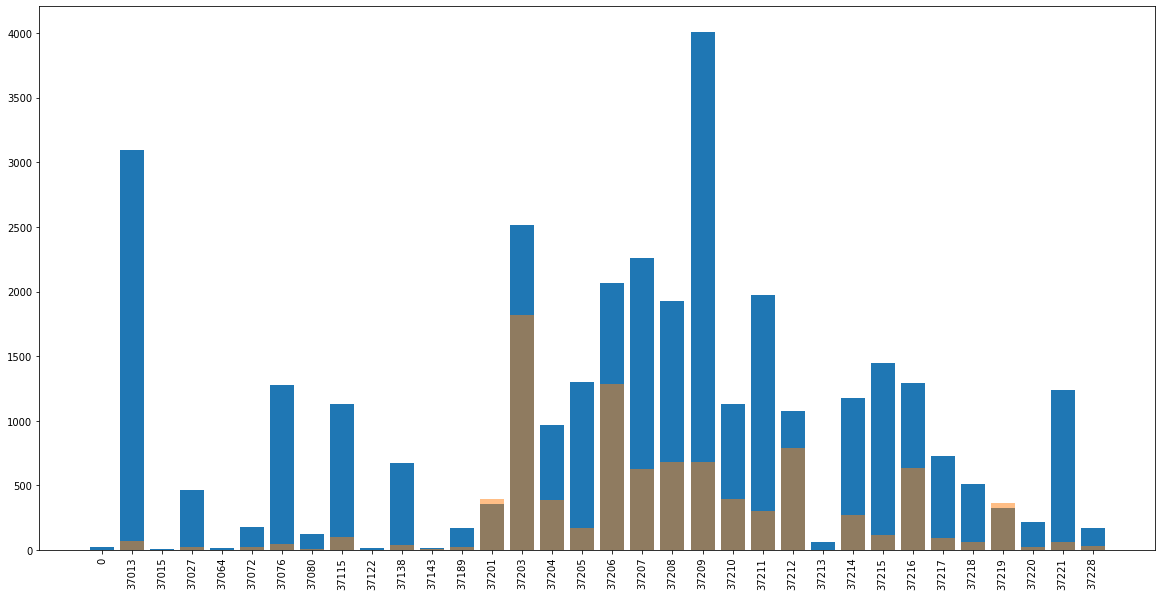

In [23]:
# Compare number of building permits and short term rental permits for each zip code (for a specific comparable year)
# Are the number of building and short term rental permits correlated?
# Are there zip that seem to have a particularly different ratio of building to short term rental permits?
# Can you find any reasons in the data why any differences might have occured?

permits_zip_vc = permits['zip'].value_counts().sort_index()
short_term_permits_zip_vc = short_term_permits['ZIP'].value_counts().sort_index()
permits_merge = pd.merge(permits_zip_vc, short_term_permits_zip_vc, how = 'inner', left_index = True, right_index = True)

plt.figure(figsize = (20, 10))
plt.bar(permits_merge.index.astype('str'), permits_merge['zip'])
plt.bar(permits_merge.index.astype('str'), permits_merge['ZIP'], alpha = 0.5)
plt.xticks(rotation = 90);

In [24]:
# You want to see how many building permits also had short term rental permits. Merge the two data sets on the 'parcel' column and check it out. Does one permit usually happen before the other?
parcel_join = pd.merge(permits, short_term_permits, left_on = 'parcel', right_on = 'Parcel', how = 'inner')
parcel_join

,number,type_desc,subtype_desc,parcel,enter_date,issue_date,cost,address,city,state,...,Permit Owner Addr. 2,Permit Owner Addr. 3,Permit Owner City,Permit Owner State,Permit Owner ZIP,Permit Type,Permit Subtype,Council District,Census Tract,Mapped Location
0,2019067047,Building Residential - Addition,Single Family Residence,08207025700,2019-11-01,2019-11-01,3500.0,226 BERRY ST,NASHVILLE,TN,...,226 BERRY ST,NaN,NASHVILLE,TN,37207,CASR,CAZ10A001,5.0,37012600,"226 BERRY ST\nNASHVILLE, TN 37207\n(36.181237, -86.76975)"
1,2019033051,Building Residential - Rehab,Single Family Residence,11810013800,2019-06-05,2019-06-05,15000.0,3424 SPRINGBROOK DR,NASHVILLE,TN,...,116 GILMAN AV,NaN,NASHVILLE,TN,37205,CASR,CAZ10A002,25.0,37017800,"3424 SPRINGBROOK DR\nNASHVILLE, TN 37204\n(36.110224, -86.779098)"
2,2019004523,Building Sign Permit,Sign - Ground / Wall Signs,09306204700,2019-01-23,2019-06-05,9000.0,109 2ND AVE N,NASHVILLE,TN,...,5039 HILL PLACE DR,NaN,NASHVILLE,TN,37205,CASR,CAZ10A003,19.0,37019500,"109 2ND AVE N 1\nNASHVILLE, TN 37201\n(36.162228, -86.775394)"
3,2019004523,Building Sign Permit,Sign - Ground / Wall Signs,09306204700,2019-01-23,2019-06-05,9000.0,109 2ND AVE N,NASHVILLE,TN,...,5039 HILL PLACE DR,NaN,NASHVILLE,TN,37205,CASR,CAZ10A003,19.0,37019500,"109 2ND AVE N 6\nNASHVILLE, TN 37201\n(36.162228, -86.775394)"
4,2019004523,Building Sign Permit,Sign - Ground / Wall Signs,09306204700,2019-01-23,2019-06-05,9000.0,109 2ND AVE N,NASHVILLE,TN,...,5039 HILL PLACE DR,NaN,NASHVILLE,TN,37205,CASR,CAZ10A003,19.0,37019500,"109 2ND AVE N 3\nNASHVILLE, TN 37201\n(36.162228, -86.775394)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6285,2018042889,Building Residential - Rehab,Detached Accessory Dwelling Unit,11704012000,2018-07-23,2018-07-24,2000.0,1506 DALLAS AVE,NASHVILLE,TN,...,1506 DALLAS AVE,NaN,NASHVILLE,TN,37212,CASR,CAZ10A001,18.0,37016900,"1506 DALLAS AVE\nNASHVILLE, TN 37212\n(36.123021, -86.792949)"
6286,2018037213,Building Residential - New,Single Family Residence,093134Q00100CO,2018-06-26,2018-06-28,370055.0,1213A HAWKINS ST,NASHVILLE,TN,...,1213 A HAWKINS ST,NaN,NASHVILLE,TN,37203,CASR,CAZ10A002,19.0,37016300,"1213A HAWKINS ST\nNASHVILLE, TN 37203\n(36.148837, -86.786553)"
6287,2018075210,Building Residential - Rehab,Single Family Residence,06009000600,2018-11-30,2018-11-30,200.0,2730 OLD MATTHEWS RD,NASHVILLE,TN,...,2730 OLD MATTHEWS RD,NaN,NASHVILLE,TN,37207,CASR,CAZ10A001,2.0,37012701,"2730 OLD MATTHEWS RD\nNASHVILLE, TN 37207\n(36.21952, -86.79227)"
6288,2018040060,Building Residential - New,Single Family Residence,093133D00200CO,2018-07-11,2018-07-23,363522.0,1315B HAWKINS ST,NASHVILLE,TN,...,1315 A Hawkins,NaN,Nashville,TN,37203,CASR,CAZ10A001,19.0,37016300,"1315B HAWKINS ST\nNASHVILLE, TN 37203\n(36.148989, -86.787999)"


In [25]:
permits[permits['parcel']=='09306204700']

,number,type_desc,subtype_desc,parcel,enter_date,issue_date,cost,address,city,state,zip,subdivision,contact,type_code,subtype_code,tracking_number,purpose,council_district,census_tract,mapped_location
315,2019004523,Building Sign Permit,Sign - Ground / Wall Signs,09306204700,2019-01-23,2019-06-05,9000.0,109 2ND AVE N,NASHVILLE,TN,37201,PT LOT 30 ORIGINAL TOWN OF NASHVILLE,JOSLIN SIGN & MAINTENANCE CO INC,CASN,CAZ02A001,3597302,"to erect 20SF illuminated projecting sign for Music City Chicken Co.\nUL#: 9587242\n\n***PURSUANT TO ORDINANCE NO 2008-1263 of the Metropolitan Code of Laws, I , holder of this permit, hereby certify that all construction and demolition waste generated by any and all activities governed by this permit shall be disposed of in an approved landfill. Further, I certify that no construction or demolition waste shall be stored on the property in violation of any provisions of the Metropolitan Cod...",19.0,37019500.0,"109 2ND AVE N\nNASHVILLE, TN 37201\n(36.162228, -86.775394)"
1437,2018057244,Building Commercial - Rehab,Restaurant (Full Service),09306204700,2018-09-07,2018-09-24,30000.0,109 2ND AVE N,NASHVILLE,TN,37201,PT LOT 30 ORIGINAL TOWN OF NASHVILLE,MP III MECHANICAL LLC,CACR,CAF19A203,3557155,interior renovation for MUSIC CITY CHICKEN COMPANY 2300 SQ.FT. to include some structural and foundation slab work \nPOC STEVE SARGENT 817-666-5275,19.0,37019500.0,"109 2ND AVE N\nNASHVILLE, TN 37201\n(36.162228, -86.775394)"
6872,2018014850,Building Sign Permit,Sign - Ground / Wall Signs,09306204700,2018-03-16,2018-06-29,7000.0,111 2ND AVE N,NASHVILLE,TN,37201,PT LOT 30 ORIGINAL TOWN OF NASHVILLE,SIGN ME UP LLC,CASN,CAZ02A001,3458862,SIGN PERMIT FOR MARKET STREET MERCHANTILE...USING PROJECTION SIGN...104 X 36 ....UL...K 46701237...\n***THIS IS NOT A USE PERMIT....SIGN PERMIT ONLY.****,19.0,37019500.0,"111 2ND AVE N\nNASHVILLE, TN 37201\n(36.162293, -86.775438)"
9500,2018067830,Building Commercial - Rehab,Restaurant (Full Service),09306204700,2018-10-25,2019-01-16,300000.0,109 2ND AVE N,NASHVILLE,TN,37201,PT LOT 30 ORIGINAL TOWN OF NASHVILLE,MP III MECHANICAL LLC,CACR,CAF19A203,3572580,"to conduct the final phase rehab work for Music City Chicken Company. DTC, MHZC and MDHA Overlays. Applicant requests John Tyler and Joseph Almon review this permit. PUBLIC WORKS STAFF PLEASE NOTE: SINCE PARCEL IS IN THE DTC, MPC WILL DETERMINE IF NEW SIDEWALKS ARE GOING TO BE REQUIRED.",19.0,37019500.0,"109 2ND AVE N\nNASHVILLE, TN 37201\n(36.162228, -86.775394)"
16428,2018044984,Building Commercial - Rehab,Restaurant (Full Service),09306204700,2018-07-31,2018-08-17,5000.0,109 2ND AVE N,NASHVILLE,TN,37201,PT LOT 30 ORIGINAL TOWN OF NASHVILLE,MP III MECHANICAL LLC,CACR,CAF19A203,3540677,interior demo of existing approx. 2300 sq. ft. space for future restaurant FOR MUSIC CITY CHEICKEN COMPANY \nPOC STEPHEN SARGENT 817-666-5275,19.0,37019500.0,"109 2ND AVE N\nNASHVILLE, TN 37201\n(36.162228, -86.775394)"


In [26]:
short_term_permits[short_term_permits['Parcel']=='09306204700']

,Permit #,Applicant,Applicant Home Phone,Applicant Mobile Phone,Applicant Work Phone,Applicant Work Phone Ext.,Contact,Contact Home Phone,Contact Mobile Phone,Contact Work Phone,...,Permit Owner Addr. 2,Permit Owner Addr. 3,Permit Owner City,Permit Owner State,Permit Owner ZIP,Permit Type,Permit Subtype,Council District,Census Tract,Mapped Location
0,2018054778,Brookside Properties,NaN,615-496-5085,NaN,NaN,Brookside Properties,NaN,615-496-5085,NaN,...,5039 HILL PLACE DR,NaN,NASHVILLE,TN,37205,CASR,CAZ10A003,19.0,37019500,"109 2ND AVE N 1\nNASHVILLE, TN 37201\n(36.162228, -86.775394)"
5,2018054829,Brookside Properties,NaN,615-496-5085,NaN,NaN,Brookside Properties,NaN,615-496-5085,NaN,...,5039 HILL PLACE DR,NaN,NASHVILLE,TN,37205,CASR,CAZ10A003,19.0,37019500,"109 2ND AVE N 6\nNASHVILLE, TN 37201\n(36.162228, -86.775394)"
9,2018054809,Brookside Properties,NaN,615-496-5085,NaN,NaN,Brookside Properties,NaN,615-496-5085,NaN,...,5039 HILL PLACE DR,NaN,NASHVILLE,TN,37205,CASR,CAZ10A003,19.0,37019500,"109 2ND AVE N 3\nNASHVILLE, TN 37201\n(36.162228, -86.775394)"
23,2018054796,Brookside Properties,NaN,615-496-5085,NaN,NaN,Brookside Properties,NaN,615-496-5085,NaN,...,5039 HILL PLACE DR,NaN,NASHVILLE,TN,37205,CASR,CAZ10A003,19.0,37019500,"109 2ND AVE N 2\nNASHVILLE, TN 37201\n(36.162228, -86.775394)"
26,2018054824,Brookside Properties,NaN,615-496-5085,NaN,NaN,Brookside Properties,NaN,615-496-5085,NaN,...,5039 HILL PLACE DR,NaN,NASHVILLE,TN,37205,CASR,CAZ10A003,19.0,37019500,"109 2ND AVE N 5\nNASHVILLE, TN 37201\n(36.162228, -86.775394)"
406,2018054814,Brookside Properties,NaN,615-496-5085,NaN,NaN,Brookside Properties,NaN,615-496-5085,NaN,...,5039 HILL PLACE DR,NaN,NASHVILLE,TN,37205,CASR,CAZ10A003,19.0,37019500,"109 2ND AVE N 4\nNASHVILLE, TN 37201\n(36.162228, -86.775394)"
6211,2018036681,Brookside Properties,NaN,615 496-5085,NaN,NaN,Brookside Properties,NaN,615 496-5085,NaN,...,5039 HILL PLACE DR,NaN,NASHVILLE,TN,37205,CASR,CAZ10A003,19.0,37019500,"109 2ND AVE N 7\nNASHVILLE, TN 37201\n(36.162228, -86.775394)"
8022,2018054832,Brookside Properties,NaN,615-496-5085,NaN,NaN,Brookside Properties,NaN,615-496-5085,NaN,...,5039 HILL PLACE DR,NaN,NASHVILLE,TN,37205,CASR,CAZ10A003,19.0,37019500,"109 2ND AVE N 8\nNASHVILLE, TN 37201\n(36.162228, -86.775394)"


---

In [27]:
permits.council_district.value_counts()

19.0    2838
20.0    2364
17.0    2232
21.0    2002
5.0     1670
33.0    1601
6.0     1381
24.0    1380
2.0     1366
25.0    1311
7.0     1188
32.0     999
15.0     951
22.0     906
11.0     879
14.0     846
18.0     841
16.0     828
31.0     781
8.0      717
23.0     680
34.0     676
3.0      644
4.0      578
35.0     564
26.0     540
9.0      534
1.0      491
13.0     486
29.0     427
28.0     405
12.0     399
10.0     336
27.0     307
30.0     274
Name: council_district, dtype: int64

In [28]:
beechwood = permits.loc[permits.address.str.contains('BEECHWOOD')]
beechwood

,number,type_desc,subtype_desc,parcel,enter_date,issue_date,cost,address,city,state,zip,subdivision,contact,type_code,subtype_code,tracking_number,purpose,council_district,census_tract,mapped_location
2227,2019038377,Building Residential - New,Detached Accessory Dwelling Unit,10416039400,2019-06-27,2019-07-02,69618.0,1516 BEECHWOOD AVE,NASHVILLE,TN,37212,PT LOT 115 BELMONT LAND CO,HAMMOND & BRANDT BUILDERS LLC,CARN,CAA11R301,3685598,"existing parcel has a base zone of R8, contains 9150 sf lot area and is in a pre 1984 recorded subdivision. this permit to construct a DADU residence with 748 sf garage and 618 sf living area. see MHZC preservation permit 2019012315. MHZC must review application. for every 50' site frontage, a 24 x 36 d/f sign must be placed in English and Spanish with information in regards to metro council bill 2017-835. Instrument recorded in book 20190701-0063823.",18.0,37016900.0,"1516 BEECHWOOD AVE\nNASHVILLE, TN 37212\n(36.125633, -86.793297)"
4548,2019020333,Building Residential - New,"Accessory Structure, Garage",10415042900,2019-04-08,2019-05-16,34455.0,2008B BEECHWOOD AVE,NASHVILLE,TN,37212,LOT 6 ESTATE OF DANIEL MCINTYRE SR.,PALMETTO CONSTRUCTION LLC,CARN,CAA14U009,3648775,"Restrictive covenant filed. instrument 20190809-0079428.\n\nto construct 608SF detached garage to the rear of existing single family residence. not to be over any easements. not to be used for living space or commercial purposes. \nMUST COMPLY WITH HCN2018069215\n***PURSUANT TO ORDINANCE NO 2008-1263 of the Metropolitan Code of Laws, I , holder of this permit, hereby certify that all construction and demolition waste generated by any and all activities governed by this permit shall be dispos...",18.0,37016900.0,"2008B BEECHWOOD AVE\nNASHVILLE, TN 37212\n(36.126899, -86.802612)"
5752,2019026170,Building Residential - Addition,Single Family Residence,10416023700,2019-05-06,2019-05-06,70000.0,1907B BEECHWOOD AVE,NASHVILLE,TN,37212,PT LOT 222 BELMONT LAND CO,mark cassani,CARA,CAA01R301,3666321,"to construct 558SF addition and conduct interior rehab to existing residence. This residence is the rear residence of a non conforming duplex lot.\nMUST COMPLY WITH HCN2019013527\n\n***PURSUANT TO ORDINANCE NO 2008-1263 of the Metropolitan Code of Laws, I , holder of this permit, hereby certify that all construction and demolition waste generated by any and all activities governed by this permit shall be disposed of in an approved landfill. Further, I certify that no construction or demolit...",18.0,37016900.0,"1907B BEECHWOOD AVE\nNASHVILLE, TN 37212\n(36.126613, -86.800918)"
6418,2019062410,Building Residential - New,Detached Accessory Dwelling Unit,10416039400,2019-10-14,2019-11-26,69618.0,1516 BEECHWOOD AVE,NASHVILLE,TN,37212,PT LOT 115 BELMONT LAND CO,"BRITT DEVELOPMENT GROUP, LLC",CARN,CAA11R301,3721794,"parcel is zoned R8 and contains 9150 sf lot area. this permit to construct a detached garage with a DADU residence. MHZC must review application. for every 50' site frontage, a 24 x 36 d/f sign must be placed in English and Spanish with information in regards to metro council bill 2017-835. instrument recorded in book 20190701-0063823.",18.0,37016900.0,"1516 BEECHWOOD AVE\nNASHVILLE, TN 37212\n(36.125633, -86.793297)"
6971,2019074099,Building Residential - Addition,Single Family Residence,10415042700,2019-12-04,2019-12-09,70406.0,2012 BEECHWOOD AVE,NASHVILLE,TN,37212,LOT 4 ESTATE OF DANIEL MCINTYRE SR.,"MITCHELL CONSTRUCTION, LLC",CARA,CAA01R301,3738075,"to construct a 625 sf addition to rear of residence and install front dormers. remains single family residence. MHZC must review application. for every 50' site frontage, a 24 x 36 d/f sign must be placed in English and Spanish with information in regards to metro council bill 2017-835. see MHZC preservation permit 2019014013.",18.0,37016900.0,"2012 BEECHWOOD AVE\nNASHVILLE, TN 37212\n(36.126931, -86.803012)"
8104,2019000729,Building Residential - Roofing / Siding,Single Family Residence,10

In [29]:
fire_stations = pd.read_csv('data/Fire_Stations.csv')
fire_stations.head()

,Station Number,Street Address,City,State,Zip Code,Mapped Location
0,Station 6,377 Haywood Lane,Nashville,TN,37211,"377 Haywood Lane\nNashville, TN 37211\n(36.068801, -86.716832)"
1,Station 29,4201 Gallatin Road,Nashville,TN,37216,"4201 Gallatin Road\nNashville, TN 37216\n(36.224081, -86.725628)"
2,Station 20,1626 Harding Place,Nashville,TN,37215,"1626 Harding Place\nNashville, TN 37215\n(36.0911, -86.82559)"
3,Station 3,840 Meridian Avenue,Nashville,TN,37207,"840 Meridian Avenue\nNashville, TN 37207\n(36.186602, -86.768085)"
4,Station 36,1000 Donelson Street,Old Hickory,TN,37138,"1000 Donelson Street\nOld Hickory, TN 37138\n(36.264093, -86.648087)"


In [30]:
fire_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
Station Number     40 non-null object
Street Address     40 non-null object
City               40 non-null object
State              40 non-null object
Zip Code           40 non-null int64
Mapped Location    39 non-null object
dtypes: int64(1), object(5)
memory usage: 2.0+ KB


In [31]:
fire_stations['Zip Code'].value_counts()

37211    4
37013    3
37207    3
37115    2
37072    2
37203    2
37205    2
37206    2
37210    2
37209    2
37212    2
37214    2
37221    2
37204    1
37080    1
37215    1
37216    1
37076    1
37217    1
37138    1
37201    1
37218    1
37208    1
Name: Zip Code, dtype: int64

In [32]:
# Could ask a leading question of what stations are in what zip code then lead into using sql to better answer

In [33]:
lat_lng_pattern = re.compile(r'\((.*),\s*(.*)\)', flags=re.MULTILINE)

def extract_lat_lng(address):
    try:
        lat_lng_match = lat_lng_pattern.search(address)
        lat = float(lat_lng_match.group(1))
        lng = float(lat_lng_match.group(2))
        return (lat, lng)
    except:
        return (np.NaN, np.NaN)  #it's important that our list be exactly as long as our df

In [34]:
lat_lngs = [extract_lat_lng(location) for location in fire_stations.loc[:, 'Mapped Location']]

fire_stations['lat'] = [lat for lat, lng in lat_lngs]
fire_stations['lng'] = [lng for lat, lng in lat_lngs]

# alternate way: list(zip(*lat_lngs))

In [35]:
districts = gpd.read_file('data/council_districts.geojson')
districts.head(2)

,first_name,email,res_phone,bus_phone,last_name,position,district,geometry
0,Nick,nick.leonardo@nashville.gov,615-509-6334,615-862-6780,Leonardo,Council Member,1,"MULTIPOLYGON (((-86.90738 36.39052, -86.90725 36.39048, -86.90712 36.39046, -86.90709 36.39046, -86.90709 36.39046, -86.90702 36.39045, -86.90679 36.39036, -86.90655 36.39027, -86.90654 36.39026, -86.90634 36.39016, -86.90609 36.39005, -86.90590 36.38997, -86.90573 36.38994, -86.90561 36.38991, -86.90552 36.38989, -86.90550 36.38988, -86.90550 36.38988, -86.90540 36.38982, -86.90532 36.38975, -86.90529 36.38973, -86.90522 36.38968, -86.90511 36.38962, -86.90492 36.38957, -86.90485 36.38955, ..."
1,DeCosta,decosta.hastings@nashville.gov,615-779-1565,615-862-6780,Hastings,Council Member,2,"MULTIPOLYGON (((-86.75902 36.23091, -86.75909 36.23053, -86.75910 36.23046, -86.75919 36.22997, -86.75922 36.22985, -86.75926 36.22959, -86.75929 36.22944, -86.75930 36.22939, -86.75936 36.22894, -86.75940 36.22867, -86.75941 36.22865, -86.75947 36.22830, -86.75957 36.22790, -86.75977 36.22716, -86.75988 36.22682, -86.75997 36.22656, -86.76022 36.22587, -86.76026 36.22575, -86.76038 36.22536, -86.76042 36.22524, -86.76053 36.22493, -86.76058 36.22479, -86.76072 36.22440, -86.76083 36.22410, ..."


In [36]:
districts['centroid'] = districts['geometry'].centroid

In [37]:
districts.head(2)

,first_name,email,res_phone,bus_phone,last_name,position,district,geometry,centroid
0,Nick,nick.leonardo@nashville.gov,615-509-6334,615-862-6780,Leonardo,Council Member,1,"MULTIPOLYGON (((-86.90738 36.39052, -86.90725 36.39048, -86.90712 36.39046, -86.90709 36.39046, -86.90709 36.39046, -86.90702 36.39045, -86.90679 36.39036, -86.90655 36.39027, -86.90654 36.39026, -86.90634 36.39016, -86.90609 36.39005, -86.90590 36.38997, -86.90573 36.38994, -86.90561 36.38991, -86.90552 36.38989, -86.90550 36.38988, -86.90550 36.38988, -86.90540 36.38982, -86.90532 36.38975, -86.90529 36.38973, -86.90522 36.38968, -86.90511 36.38962, -86.90492 36.38957, -86.90485 36.38955, ...",POINT (-86.89460 36.26267)
1,DeCosta,decosta.hastings@nashville.gov,615-779-1565,615-862-6780,Hastings,Council Member,2,"MULTIPOLYGON (((-86.75902 36.23091, -86.75909 36.23053, -86.75910 36.23046, -86.75919 36.22997, -86.75922 36.22985, -86.75926 36.22959, -86.75929 36.22944, -86.75930 36.22939, -86.75936 36.22894, -86.75940 36.22867, -86.75941 36.22865, -86.75947 36.22830, -86.75957 36.22790, -86.75977 36.22716, -86.75988 36.22682, -86.75997 36.22656, -86.76022 36.22587, -86.76026 36.22575, -86.76038 36.22536, -86.76042 36.22524, -86.76053 36.22493, -86.76058 36.22479, -86.76072 36.22440, -86.76083 36.22410, ...",POINT (-86.80271 36.20859)


''

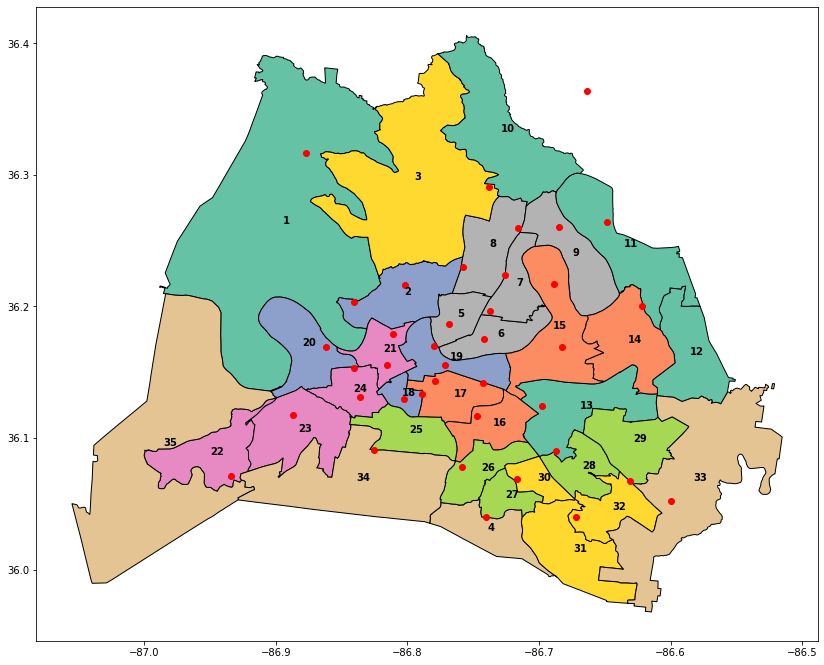

In [38]:
fig, ax = plt.subplots(figsize = (14, 14))
districts.plot(column = 'district', ax = ax, cmap = 'Set2', edgecolor = 'black')
for _, df in districts[['district', 'centroid']].iterrows():
    ax.annotate(df['district'], xy=(df['centroid'].x, df['centroid'].y), weight = 'bold')
plt.scatter(fire_stations.lng, fire_stations.lat, c = 'red')
;

In [39]:
fire_stations['geometry'] = fire_stations.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)

In [40]:
fire_geo = gpd.GeoDataFrame(fire_stations, crs = districts.crs, geometry = fire_stations.geometry)

In [41]:
fire_geo.head()

,Station Number,Street Address,City,State,Zip Code,Mapped Location,lat,lng,geometry
0,Station 6,377 Haywood Lane,Nashville,TN,37211,"377 Haywood Lane\nNashville, TN 37211\n(36.068801, -86.716832)",36.068801,-86.716832,POINT (-86.71683 36.06880)
1,Station 29,4201 Gallatin Road,Nashville,TN,37216,"4201 Gallatin Road\nNashville, TN 37216\n(36.224081, -86.725628)",36.224081,-86.725628,POINT (-86.72563 36.22408)
2,Station 20,1626 Harding Place,Nashville,TN,37215,"1626 Harding Place\nNashville, TN 37215\n(36.0911, -86.82559)",36.091100,-86.825590,POINT (-86.82559 36.09110)
3,Station 3,840 Meridian Avenue,Nashville,TN,37207,"840 Meridian Avenue\nNashville, TN 37207\n(36.186602, -86.768085)",36.186602,-86.768085,POINT (-86.76808 36.18660)
4,Station 36,1000 Donelson Street,Old Hickory,TN,37138,"1000 Donelson Street\nOld Hickory, TN 37138\n(36.264093, -86.648087)",36.264093,-86.648087,POINT (-86.64809 36.26409)


In [42]:
stations = gpd.sjoin(districts, fire_geo, op = 'contains' )
stations.head(2)

/Users/maheshrao/anaconda3/envs/jumpstart/lib/python3.7/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


,first_name,email,res_phone,bus_phone,last_name,position,district,geometry,centroid,index_right,Station Number,Street Address,City,State,Zip Code,Mapped Location,lat,lng
0,Nick,nick.leonardo@nashville.gov,615-509-6334,615-862-6780,Leonardo,Council Member,1,"MULTIPOLYGON (((-86.90738 36.39052, -86.90725 36.39048, -86.90712 36.39046, -86.90709 36.39046, -86.90709 36.39046, -86.90702 36.39045, -86.90679 36.39036, -86.90655 36.39027, -86.90654 36.39026, -86.90634 36.39016, -86.90609 36.39005, -86.90590 36.38997, -86.90573 36.38994, -86.90561 36.38991, -86.90552 36.38989, -86.90550 36.38988, -86.90550 36.38988, -86.90540 36.38982, -86.90532 36.38975, -86.90529 36.38973, -86.90522 36.38968, -86.90511 36.38962, -86.90492 36.38957, -86.90485 36.38955, ...",POINT (-86.89460 36.26267),28,Station 30,3705 Old Clarksville Pike,Joelton,TN,37080,"3705 Old Clarksville Pike\nJoelton, TN 37080\n(36.316384, -86.876877)",36.316384,-86.876877
1,DeCosta,decosta.hastings@nashville.gov,615-779-1565,615-862-6780,Hastings,Council Member,2,"MULTIPOLYGON (((-86.75902 36.23091, -86.75909 36.23053, -86.75910 36.23046, -86.75919 36.22997, -86.75922 36.22985, -86.75926 36.22959, -86.75929 36.22944, -86.75930 36.22939, -86.75936 36.22894, -86.75940 36.22867, -86.75941 36.22865, -86.75947 36.22830, -86.75957 36.22790, -86.75977 36.22716, -86.75988 36.22682, -86.75997 36.22656, -86.76022 36.22587, -86.76026 36.22575, -86.76038 36.22536, -86.76042 36.22524, -86.76053 36.22493, -86.76058 36.22479, -86.76072 36.22440, -86.76083 36.22410, ...",POINT (-86.80271 36.20859),8,Station 24,3851 Clarksville Highway,Nashville,TN,37218,"3851 Clarksville Highway\nNashville, TN 37218\n(36.203627, -86.840622)",36.203627,-86.840622


#### looking at the shapes tells me I lost 2 fire stations when I did a spatial join. The one NE of the council districts makes sense...what about the other one?

In [43]:
fire_geo['Station Number'].isin(stations['Station Number'])

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18    False
19     True
20    False
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28     True
29     True
30     True
31     True
32     True
33     True
34     True
35     True
36     True
37     True
38     True
39     True
Name: Station Number, dtype: bool

#### Station 41 is beyond council districts; Station 34 does not have lat/lng - will need to decide whether to geocode or drop 34

In [44]:
fire_stations.iloc[18:21, :]

,Station Number,Street Address,City,State,Zip Code,Mapped Location,lat,lng,geometry
18,Station 41,105 Long Hollow Pk,Goodlettsville,TN,37072,"105 Long Hollow Pk\nGoodlettsville, TN 37072\n(36.363516, -86.663892)",36.363516,-86.663892,POINT (-86.664 36.364)
19,Station 17,3911 West End Avenue,Nashville,TN,37205,"3911 West End Avenue\nNashville, TN 37205\n(36.13091, -86.835975)",36.130910,-86.835975,POINT (-86.836 36.131)
20,Station 34,8350 Highway 70 South,Nashville,TN,37221,NaN,NaN,NaN,POINT (nan nan)


In [45]:
stations = stations[['district', 'Station Number', 
                     'Street Address', 'City', 'State', 'Zip Code', 'lat', 'lng']]

In [46]:
stations.columns = ['district', 'station_number', 'address',
       'city', 'state', 'zipcode', 'lat', 'lng']

In [48]:
stations = stations.drop('zipcode', axis = 1)

In [49]:
# learn what this is doing

engine = create_engine('sqlite:///stations.db')

stations.to_sql('fire_stations', engine, index=False, if_exists='replace')

In [50]:
test = pd.read_sql('select * from fire_stations', engine)

In [51]:
test.shape

(38, 7)

In [52]:
test.head()

,district,station_number,address,city,state,lat,lng
0,1,Station 30,3705 Old Clarksville Pike,Joelton,TN,36.316384,-86.876877
1,2,Station 24,3851 Clarksville Highway,Nashville,TN,36.203627,-86.840622
2,2,Station 25,2589 Whites Creek Pike,Nashville,TN,36.215851,-86.801616
3,8,Station 1,130 Broadmoor Avenue,Nashville,TN,36.229579,-86.757426
4,8,Station 31,415 Douglas Avenue,Madison,TN,36.259135,-86.716084
